In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from utils.common import day_aware_shift, plot_confusion_matrix
from utils.features import create_lag, create_rsi, create_dst, create_ma_ratio, create_z
from utils.model import XGBoostClassifier, LogisticClassifier

import os
import ta
import tabulate
import datetime
import tqdm
import pickle

In [2]:
df_wti_1m = pickle.load(open('./large_files/cl-1m.pkl', 'rb'))
df_wti_1m = df_wti_1m[(df_wti_1m['datetime'].dt.hour >= 8) & (df_wti_1m['datetime'].dt.hour <= 16)]

df = df_wti_1m.copy()
df = df[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 16)]
# df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
df['month'] = df['datetime'].dt.month
df['month'] = pd.Categorical(df['month'])
df.head()

,date,time,open,high,low,close,volume,datetime,day,month
583,2007-04-02,0800,65.66,65.69,65.66,65.69,6,2007-04-02 08:00:00-04:00,Monday,4
584,2007-04-02,0801,65.67,65.67,65.65,65.66,3,2007-04-02 08:01:00-04:00,Monday,4
585,2007-04-02,0802,65.67,65.70,65.67,65.70,13,2007-04-02 08:02:00-04:00,Monday,4
586,2007-04-02,0803,65.69,65.70,65.68,65.70,6,2007-04-02 08:03:00-04:00,Monday,4
587,2007-04-02,0804,65.70,65.77,65.70,65.77,16,2007-04-02 08:04:00-04:00,Monday,4


In [3]:
def feature_pipeline(df):
    for period in [5, 15, 30, 60]:
        df = create_z(df, period, 'close')
        df = create_z(df, period, 'volume')
        df = create_dst(df, [period])
        df = create_rsi(df, [period])

        for sub_period in [5, 15, 30, 60]:
            df = create_lag(df, f'z_close_{period}m', sub_period)
            df = create_lag(df, f'z_volume_{period}m', sub_period)
            df = create_lag(df, f'dst_high_{period}m', sub_period)
            df = create_lag(df, f'dst_low_{period}m', sub_period)

            if sub_period > period:
                df = create_ma_ratio(df, period, sub_period)

    return df

def target_pipeline(df):
    df['trend_30m_z5'] = (df['z_close_30m'] > 0).int
    df = day_aware_shift(df, 'trend_30m_z5', -5)

    return df

In [4]:
df = feature_pipeline(df)
df.info()

  3%|▎         | 156/6085 [00:00<00:03, 1549.96it/s]

100%|██████████| 6085/6085 [00:04<00:00, 1305.49it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040372 entries, 0 to 2040371
Columns: 136 entries, date to lag60m_dst_low_60m
dtypes: category(1), datetime64[ns, America/New_York](1), float64(130), int64(1), object(3)
memory usage: 2.1+ GB


In [5]:
df = target_pipeline(df)

AttributeError: 'Series' object has no attribute 'int'

In [ ]:
# Wednesday
df2 = df[df['datetime'].dt.hour >= 9]
df2 = df2[df2['datetime'].dt.day_of_week == 2]
df2['month'] = pd.Categorical(df2['month'])

to_drop = ['date', 'datetime', 'time', 'day', 'open', 'high', 'low', 'close', 'volume', 'trend_30m_z5'] + \
    [f for f in df.columns if 'sma' in f]

Xtr = df2[df2['datetime'].dt.year < 2018]
Xvl = df2[df2['datetime'].dt.year == 2018]
Xte = df2[df2['datetime'].dt.year == 2019]

le = LabelEncoder()

ytr = le.fit_transform(Xtr['trend_30m_z5']).reshape(-1, 1)
yvl = le.transform(Xvl['trend_30m_z5']).reshape(-1, 1)
yte = le.transform(Xte['trend_30m_z5']).reshape(-1, 1)

Xtr = Xtr.drop(to_drop, axis=1)
Xvl = Xvl.drop(to_drop, axis=1)
Xte = Xte.drop(to_drop, axis=1)

In [ ]:
params = {
    'objective': 'binary:logistic',
    'random_state': 42,
    'learning_rate': 0.05,
    'nthread': -1,
    'max_depth': 5,
    'early_stopping_rounds': 10,
    'tree_method': 'hist',
    'enable_categorical': True,
    'device': 'cuda'
}

xgb = XGBoostClassifier(params=params)
xgb.fit((Xtr, ytr), (Xvl, yvl), le.classes_)

Training XGBClassifier with the following params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'nthread': -1}
Training Results:
+-----------+------+
| accuracy  | 0.99 |
| precision | 0.99 |
| recall    | 0.99 |
| f1        | 0.99 |
+-----------+------+

Validation Results:
+-----------+------+
| accuracy  | 0

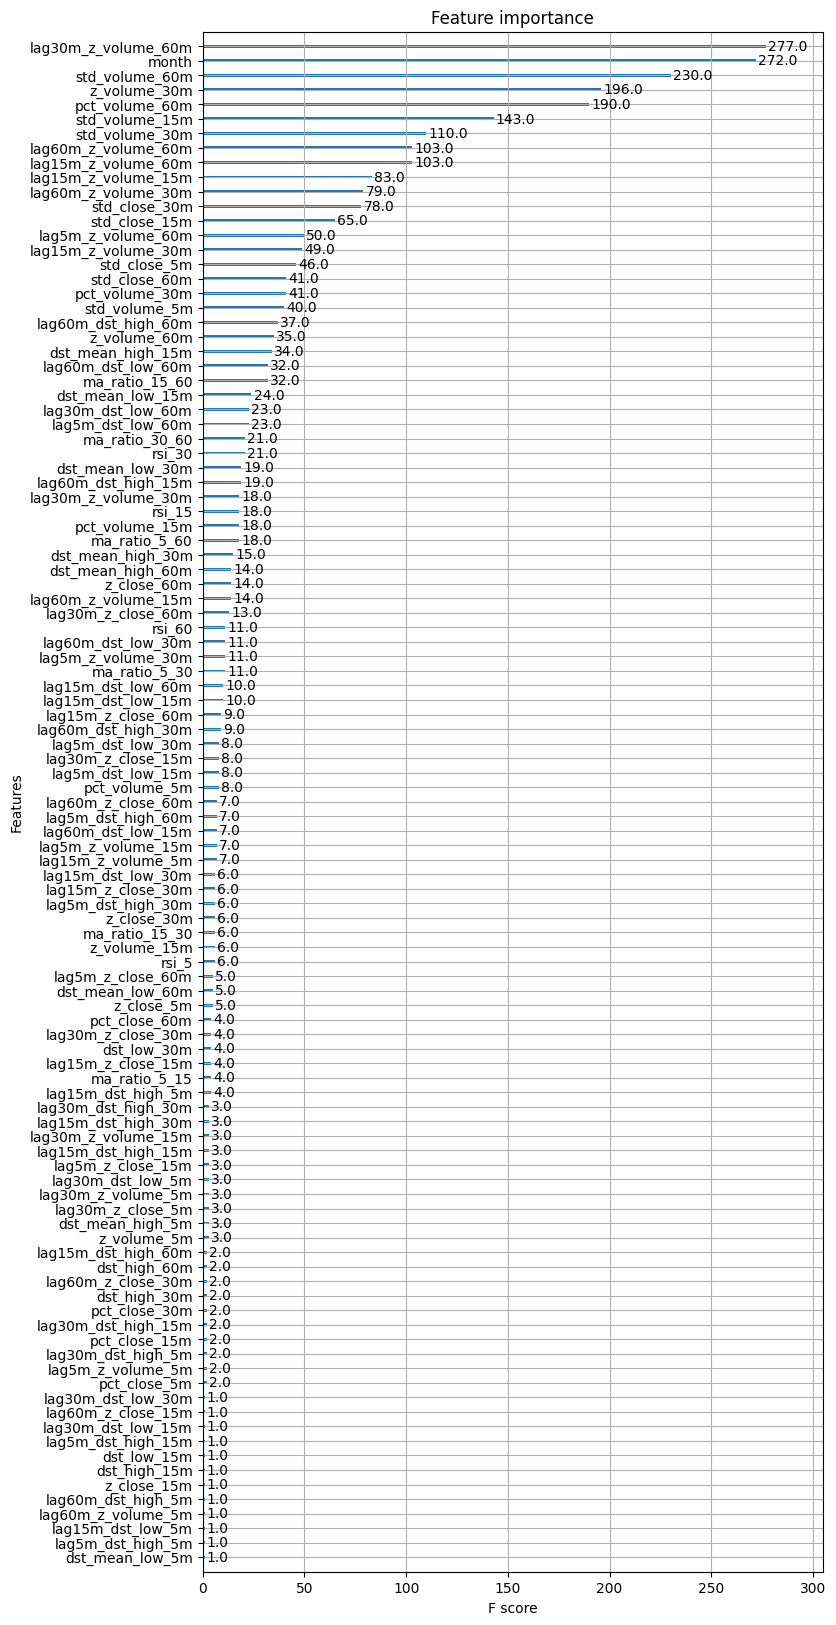

In [ ]:
xgb.plot_importance((8, 20))